<a href="https://colab.research.google.com/github/AfricaMachineIntelligence/opengesture/blob/main/OpenGesture_OAK_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 Open Gesture Authors integrated notebook.
##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Gesture Image Classifier - Transfer Learning Approach


<table class="tfo-notebook-buttons" align="left">
  <!-- <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td> -->
  <td>
    <a target="_blank" href="https://github.com/AfricaMachineIntelligence/opengesture"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/AfricaMachineIntelligence/opengesture"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <!-- <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td> -->
</table>

## Introduction



This Colab demonstrates the use of OpenVINO Toolkit to optimize and prepare a blob from a Keras model that classifies 10 gestures from OpenGesture 3D Dataset Sign Language Digits by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset.




## Setup

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.5.0
Hub version: 0.12.0
GPU is available


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [ ]:
model_name = "mobilenet_v3_large_100_224" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE =  16#@param {type:"integer"}

Selected model: mobilenet_v3_large_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
Input size (224, 224)


## Set up the Gesture dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [ ]:
data_dir = tf.keras.utils.get_file(
    'opengesture-data',
    'https://planetg.s3.amazonaws.com/opengesture-data.tar.xz',
    untar=True)

In [ ]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(
    1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 2662 files belonging to 10 classes.
Using 2130 files for training.
Found 2662 files belonging to 10 classes.
Using 532 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              4226432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,239,242
Trainable params: 12,810
Non-trainable params: 4,226,432
_________________________________________________________________


## Training the model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=100, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/100
133/133 [==============================] - 51s 381ms/step - loss: 1.1998 - accuracy: 0.7176 - val_loss: 1.2926 - val_accuracy: 0.6818
Epoch 2/100
133/133 [==============================] - 50s 380ms/step - loss: 1.2154 - accuracy: 0.7058 - val_loss: 1.2335 - val_accuracy: 0.6932
Epoch 3/100
133/133 [==============================] - 50s 377ms/step - loss: 1.1990 - accuracy: 0.7096 - val_loss: 1.2169 - val_accuracy: 0.7045
Epoch 4/100
133/133 [==============================] - 50s 376ms/step - loss: 1.1964 - accuracy: 0.7190 - val_loss: 1.1696 - val_accuracy: 0.7519
Epoch 5/100
133/133 [==============================] - 49s 368ms/step - loss: 1.1456 - accuracy: 0.7370 - val_loss: 1.2022 - val_accuracy: 0.6970
Epoch 6/100
133/133 [==============================] - 49s 370ms/step - loss: 1.1861 - accuracy: 0.7204 - val_loss: 1.2799 - val_accuracy: 0.6799
Epoch 7/100
133/133 [==============================] - 50s 374ms/step - loss: 1.1795 - accuracy: 0.7389 - val_loss: 1.1653 -

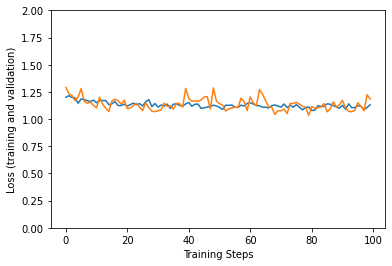

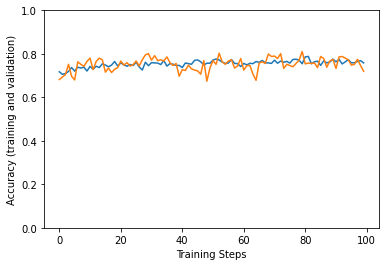

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

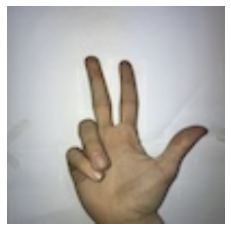

True label: three
Predicted label: three


In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

**Finally, the trained model can be saved for deployment to OpenCV OAK-D using Intel OpenVINO Toolkit.**

In [ ]:
model_fname="gesture"
model.save(model_fname)

INFO:tensorflow:Assets written to: gesture/assets


INFO:tensorflow:Assets written to: gesture/assets


In [ ]:
print("This will take a while...")
!wget -O openvino_key https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691&erpm_id=9830841_ts1607381885691&elq_cid=6770273_ts1607381960247&erpm_id=9830841_ts1607381960247 
!apt-key add openvino_key
#!apt-key -q list
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" | tee /etc/apt/sources.list.d/intel-openvino-2021.list
!apt update -q
!apt-cache search intel-openvino-dev-ubuntu18
!apt-get install intel-openvino-dev-ubuntu18-2021.2.200 -y -q
!pip install -U --no-deps --quiet openvino

#unknown bug - this is just a patch
!cp /opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib/libtbb.so /usr/lib/x86_64-linux-gnu/libtbb.so
!cp /opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib/libtbb.so.2 /usr/lib/x86_64-linux-gnu/libtbb.so.2
!ldconfig
print("Installation Completed...")
#%env we can set environmental variable with this

#Run the validation
!ls /opt/intel/
#Run the Validation Demo code.
demo_cmd = "/opt/intel/openvino_2021/deployment_tools/demo/demo_squeezenet_download_convert_run.sh"
import os
import subprocess
import shutil
output = subprocess.check_output(demo_cmd, shell=True)
print (output.decode('utf-8'))     

This will take a while...
--2021-08-06 21:11:07--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691
Resolving apt.repos.intel.com (apt.repos.intel.com)... 104.105.115.4, 2600:1406:3f:a95::4b23, 2600:1406:3f:a90::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|104.105.115.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘openvino_key’

openvino_key        100%[===================>]     939  --.-KB/s    in 0s      

2021-08-06 21:11:07 (142 MB/s) - ‘openvino_key’ saved [939/939]

OK
deb https://apt.repos.intel.com/openvino/2021 all main
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com

In [ ]:
source_cmd= "/opt/intel/openvino_2021/bin/setupvars.sh"

# Setup model optimizer command ...
ir_name = "gesture"
ir_data_type = "FP32"
ir_out_dir = f"{model_fname}/IR_models/{ir_data_type}"
ir_input_shape = "[1,224,224,3]"
mo_cmd = f"/opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py \
      --saved_model_dir {model_fname} \
      --input_shape {ir_input_shape} \
      --data_type {ir_data_type} \
      --output_dir {ir_out_dir}  \
      --model_name {ir_name}"
print ("Running model optimizer to convert model to OpenVINO IR format ....")
print("\n--".join(mo_cmd.split("--")))

output = subprocess.check_output(source_cmd+" && "+mo_cmd, shell=True)
print (output.decode('utf-8'))     

Running model optimizer to convert model to OpenVINO IR format ....
/opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py       
--saved_model_dir gesture       
--input_shape [1,224,224,3]       
--data_type FP32       
--output_dir gesture/IR_models/FP32        
--model_name gesture
[setupvars.sh] OpenVINO environment initialized
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/content/gesture/IR_models/FP32
	- IR output name: 	gesture
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels:

gesture  openvino_key  sample_data
gesture  openvino_key  sample_data


**Convert OpenVINO IR to Blob format**

In [ ]:
!cp /opt/intel/openvino_2021.2.200/deployment_tools/inference_engine/lib/intel64/libmyriadPlugin.so /usr/lib/x86_64-linux-gnu/libmyriadPlugin.so
!source /opt/intel/openvino_2021/bin/setupvars.sh && /opt/intel/openvino_2021/deployment_tools/inference_engine/lib/intel64/myriad_compile -m /content/gesture/IR_models/FP32/gesture.xml -ip U8 -VPU_NUMBER_OF_SHAVES 4 -VPU_NUMBER_OF_CMX_SLICES 4

[setupvars.sh] OpenVINO environment initialized
Inference Engine: 
	API version ............ 2.1
	Build .................. 2021.2.0-1877-176bdf51370-releases/2021/2
	Description ....... API
[Warning][VPU][Config] Deprecated option was used : VPU_MYRIAD_PLATFORM
Done


**Download Gesture Model Blob to local machine**

In [ ]:
!ls gesture/IR_models/FP32/
#download the blob file to local directory.
from google.colab import files
files.download('gesture/IR_models/FP32/gesture.blob')

#if you want everything - uncomment these two lines
!zip -r opengesture.zip gesture 
files.download('opengesture.zip')

gesture.bin  gesture.blob  gesture.mapping  gesture.xml


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: gesture/ (stored 0%)
  adding: gesture/keras_metadata.pb (deflated 80%)
  adding: gesture/IR_models/ (stored 0%)
  adding: gesture/IR_models/FP32/ (stored 0%)
  adding: gesture/IR_models/FP32/gesture.xml (deflated 95%)
  adding: gesture/IR_models/FP32/gesture.bin (deflated 7%)
  adding: gesture/IR_models/FP32/gesture.blob (deflated 34%)
  adding: gesture/IR_models/FP32/gesture.mapping (deflated 97%)
  adding: gesture/saved_model.pb (deflated 92%)
  adding: gesture/assets/ (stored 0%)
  adding: gesture/variables/ (stored 0%)
  adding: gesture/variables/variables.index (deflated 77%)
  adding: gesture/variables/variables.data-00000-of-00001 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>